# LEGO Dataset Project: Loading and Analyzing Data in MySQL

**Objetivo del Proyecto**: Este proyecto tiene como objetivo la carga de varios archivos CSV relacionados con sets de LEGO en una base de datos MySQL, y realizar análisis sobre los datos. El propósito es practicar la manipulación de bases de datos usando SQL y Python. Además, se realizarán consultas SQL avanzadas para extraer información útil del dataset, como los colores más populares, sets publicados por año, etc.



### Librerías 

Utilizaremos **pandas** para la manipulación de datos, **SQLAlchemy** para la conexión con MySQL y **matplotlib** o **seaborn** para visualizar los datos obtenidos a partir de las queries de SQL.

In [1]:
import pandas as pd
import pymysql
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Configuración de gráficos con Seaborn
sns.set(style="whitegrid")

### Configuración de la Conexión a la Base de Datos

Aquí configuramos la conexión con la base de datos MySQL que contiene la información de LEGO. Para esto, utilizamos SQLAlchemy que nos permite conectarnos de manera eficiente.

In [2]:

# Configuración de la base de datos y la conexión
bd = "lego_inventory"
password = "1234"
connection_string = 'mysql+pymysql://root:' + password + '@localhost/' + bd
engine = create_engine(connection_string)



### Análisis: Cantidad de Piezas por Color

Esta consulta nos muestra los 10 colores más comunes en las piezas de LEGO según el número total de piezas que aparecen en el inventario.

In [3]:
# Colores más comunes
consulta = '''SELECT c.colors_name, c.rgb, COUNT(ip.part_num) AS total_pieces
FROM colors c
JOIN inventory_parts ip ON c.id = ip.color_id
GROUP BY c.colors_name, c.rgb
ORDER BY total_pieces DESC
LIMIT 10;'''  
num_piezas_by_color = pd.read_sql(consulta, con=engine)

In [4]:
num_piezas_by_color

,colors_name,rgb,total_pieces
0,Black,05131D,115085
1,White,FFFFFF,66536
2,Light Bluish Gray,A0A5A9,55302
3,Red,C91A09,50213
4,Dark Bluish Gray,6C6E68,43907
5,Yellow,F2CD37,38831
6,Blue,0055BF,29855
7,Light Gray,9BA19D,25323
8,Reddish Brown,582A12,14164
9,Tan,E4CD9E,13680


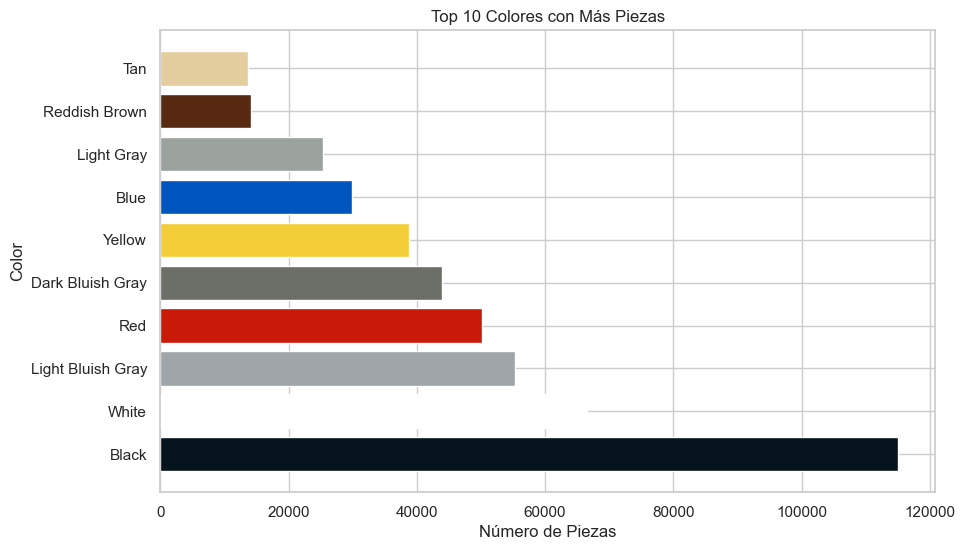

In [5]:
# Convertir el color RGB en formato hexadecimal
num_piezas_by_color['color_hex'] = num_piezas_by_color['rgb'].apply(lambda x: f'#{x}')

# Crear gráfico
plt.figure(figsize=(10, 6))
bars = plt.barh(num_piezas_by_color['colors_name'], num_piezas_by_color['total_pieces'], color=num_piezas_by_color['color_hex'])

# Ajustar el título y las etiquetas
plt.title('Top 10 Colores con Más Piezas')
plt.xlabel('Número de Piezas')
plt.ylabel('Color')

plt.show()

### Análisis: Piezas Transparentes vs No Transparentes

Esta consulta cuenta cuántas piezas transparentes y no transparentes hay en el dataset.

In [6]:
# Piezas transparentes y no transparente
consulta = '''SELECT 
    c.is_trans,
    COUNT(ip.part_num) AS total_pieces
FROM 
    inventory_parts ip
JOIN 
    colors c ON ip.color_id = c.id
GROUP BY 
    c.is_trans;'''
trans_parts = pd.read_sql(consulta, con=engine)

In [7]:
trans_parts

,is_trans,total_pieces
0,0,543751
1,1,36318


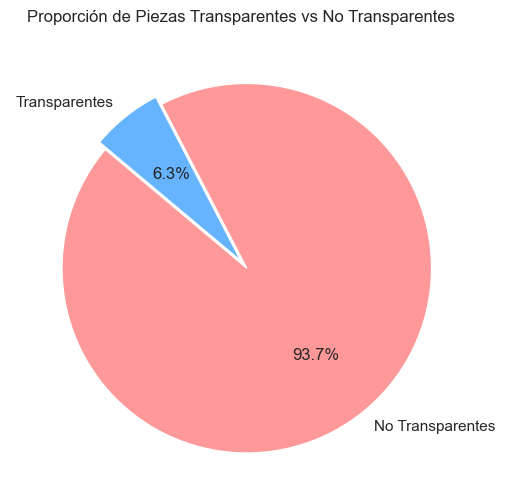

In [8]:
# Gráfico de pastel - Piezas transparentes vs no transparentes
labels = ['No Transparentes', 'Transparentes']
sizes = trans_parts['total_pieces']
colors = ['#ff9999','#66b3ff']
explode = (0.05, 0)  # resaltar una porción

plt.figure(figsize=(6,6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Proporción de Piezas Transparentes vs No Transparentes')
plt.show()

### Piezas Transparentes y No Transparentes a lo Largo de los Años
Aquí realizamos un análisis más detallado, observando la cantidad de piezas transparentes y no transparentes distribuidas a lo largo de los años.

In [9]:
# partes transparentes y no transparente a lo largo de los años
consulta = '''
SELECT 
    s.published_year,
    c.is_trans,
    COUNT(ip.part_num) AS total_pieces
FROM 
    inventory_parts ip
JOIN 
    colors c ON ip.color_id = c.id
JOIN 
    inventories i ON ip.inventory_id = i.id
JOIN 
    sets s ON i.set_num = s.set_num
GROUP BY 
    s.published_year, c.is_trans
ORDER BY 
    s.published_year, c.is_trans;'''
trans_parts_by_year = pd.read_sql(consulta, con=engine)

In [10]:
trans_parts_by_year

,published_year,is_trans,total_pieces
0,1950,0,44
1,1950,1,2
2,1953,0,18
3,1954,0,97
4,1954,1,1
...,...,...,...
126,2015,1,3636
127,2016,0,46232
128,2016,1,3669
129,2017,0,25519


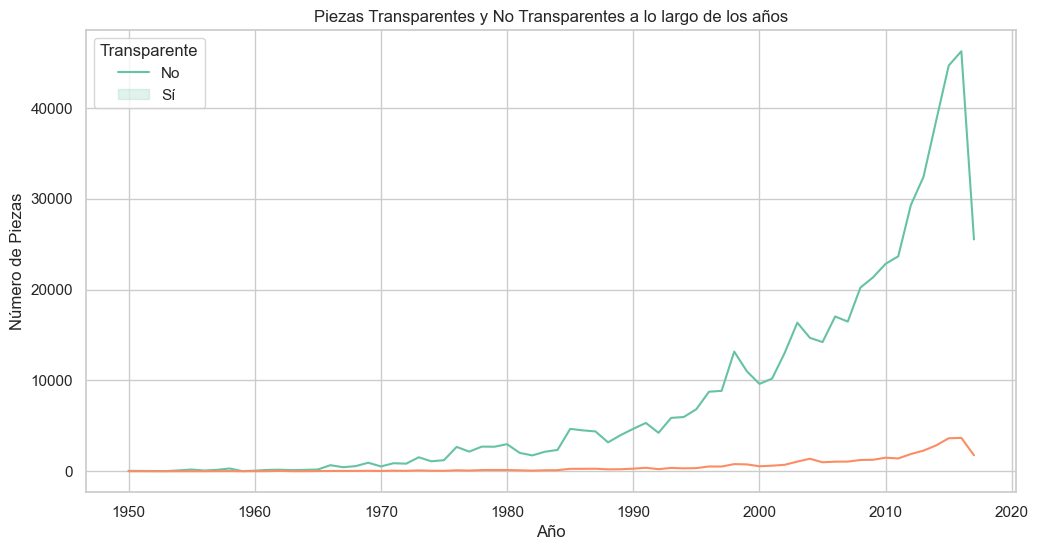

In [11]:
# Gráfico de líneas - Piezas transparentes y no transparentes a lo largo de los años
plt.figure(figsize=(12,6))
sns.lineplot(x='published_year', y='total_pieces', hue='is_trans', data=trans_parts_by_year, palette='Set2')
plt.title('Piezas Transparentes y No Transparentes a lo largo de los años')
plt.xlabel('Año')
plt.ylabel('Número de Piezas')
plt.legend(title='Transparente', labels=['No', 'Sí'])
plt.show()

### Cantidad de Sets Publicados por Año
Aquí observamos cuántos sets de LEGO se publicaron en cada año, permitiendo ver la popularidad de LEGO a lo largo del tiempo.

In [12]:
# Cantidad de set publicados por años
consulta = '''SELECT published_year, COUNT(*) AS total_sets FROM sets 
GROUP BY published_year
ORDER BY total_sets DESC;'''
sets_by_year = pd.read_sql(consulta, con=engine)

In [13]:
sets_by_year

,published_year,total_sets
0,2014,713
1,2015,665
2,2012,615
3,2016,596
4,2013,593
...,...,...
61,1965,10
62,1950,7
63,1953,4
64,1959,4


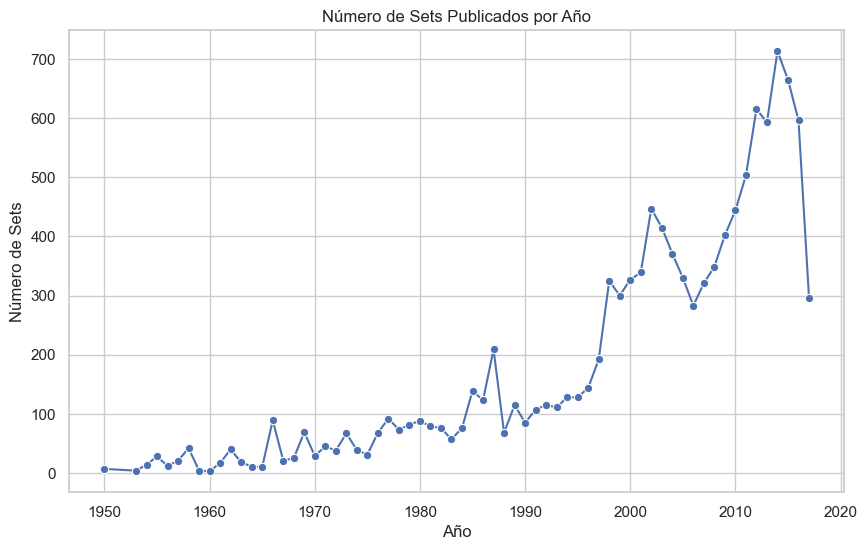

In [14]:
# Gráfico de líneas - Cantidad de sets publicados por año
plt.figure(figsize=(10,6))
sns.lineplot(x='published_year', y='total_sets', data=sets_by_year, marker='o')
plt.title('Número de Sets Publicados por Año')
plt.xlabel('Año')
plt.ylabel('Número de Sets')
plt.show()

### Top 50 de temas más populares

Esta consulta selecciona los 50 temas que tienen más sets publicados.

In [15]:
# Cantidad de set publicados por tema mas popular en cada año 
consulta = '''SELECT 
    t.themes_name, 
    COUNT(s.set_num) AS total_sets
FROM 
    themes t
JOIN 
    sets s ON t.id = s.theme_id
GROUP BY 
    t.themes_name
ORDER BY 
    total_sets DESC
LIMIT 50;'''
top_50_themes = pd.read_sql(consulta, con=engine)

In [16]:
top_50_themes

,themes_name,total_sets
0,Supplemental,496
1,Technic,435
2,City,287
3,Friends,269
4,Basic Set,257
5,Creator,249
6,Gear,246
7,Service Packs,242
8,Duplo,219
9,Star Wars,211


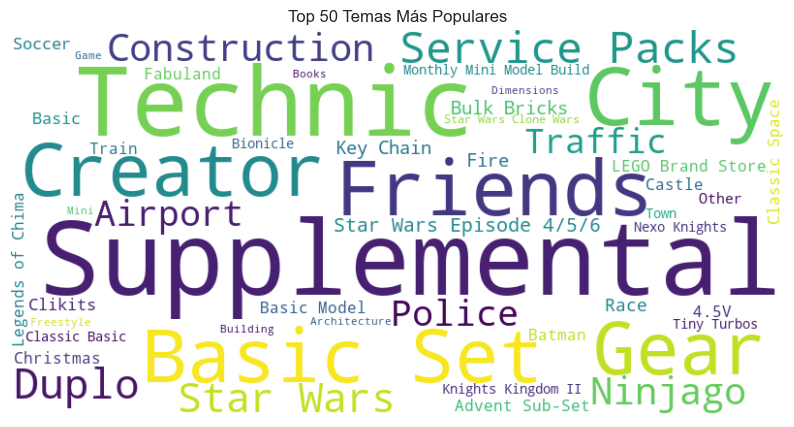

In [17]:
# Crear un diccionario con los temas y el número de sets
theme_dict = dict(zip(top_50_themes['themes_name'], top_50_themes['total_sets']))

# Generar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(theme_dict)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No mostrar ejes
plt.title('Top 50 Temas Más Populares')
plt.show()

### Media de las Partes por Set a lo Largo de los Años

Este análisis muestra la cantidad promedio de partes por set en cada año, lo que puede dar una idea de si los sets están volviéndose más complejos con el tiempo.

In [18]:
# media de las partes por set a lo largo de los años    
consulta = '''SELECT 
    s.published_year,
    SUM(ip.quantity) / COUNT(DISTINCT s.set_num) AS avg_parts_per_set
FROM 
    sets s
JOIN 
    inventories i ON s.set_num = i.set_num
JOIN 
    inventory_parts ip ON i.id = ip.inventory_id
GROUP BY 
    s.published_year
ORDER BY 
    s.published_year;'''
media_parts_by_year = pd.read_sql(consulta, con=engine)
    

In [19]:
media_parts_by_year

,published_year,avg_parts_per_set
0,1950,10.1429
1,1953,16.5000
2,1954,12.3571
3,1955,38.4444
4,1956,20.1818
...,...,...
61,2013,203.1963
62,2014,211.0236
63,2015,235.2287
64,2016,264.3237


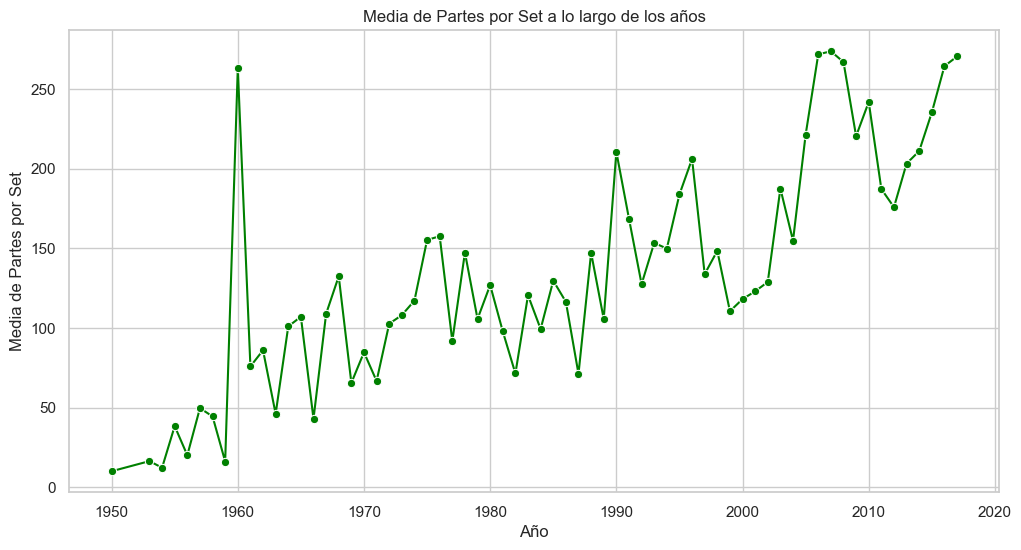

In [20]:
# Gráfico de líneas - Media de las partes por set a lo largo de los años
plt.figure(figsize=(12,6))
sns.lineplot(x='published_year', y='avg_parts_per_set', data=media_parts_by_year, marker='o', color='green')
plt.title('Media de Partes por Set a lo largo de los años')
plt.xlabel('Año')
plt.ylabel('Media de Partes por Set')
plt.show()

### Colores Más Raros

Aquí se listan los colores más raros, es decir, aquellos con menos piezas asociadas en el inventario.

In [21]:
# Rare Colors:
consulta = '''SELECT 
    c.colors_name, c.rgb,
    COUNT(ip.part_num) AS total_pieces
FROM 
    colors c
JOIN 
    inventory_parts ip ON c.id = ip.color_id
GROUP BY 
    c.colors_name, c.rgb
ORDER BY 
    total_pieces ASC
LIMIT 10;'''
rare_colors= pd.read_sql(consulta, con=engine)

In [22]:
rare_colors

,colors_name,rgb,total_pieces
0,Trans Light Royal Blue,B4D4F7,1
1,Chrome Green,3CB371,2
2,Medium Violet,9391E4,2
3,Very Light Orange,F3CF9B,2
4,Very Light Gray,E6E3DA,2
5,Salmon,F2705E,3
6,Chrome Black,1B2A34,3
7,Pearl Very Light Gray,ABADAC,4
8,Dark Blue-Violet,2032B0,4
9,Speckle Black-Copper,000000,5


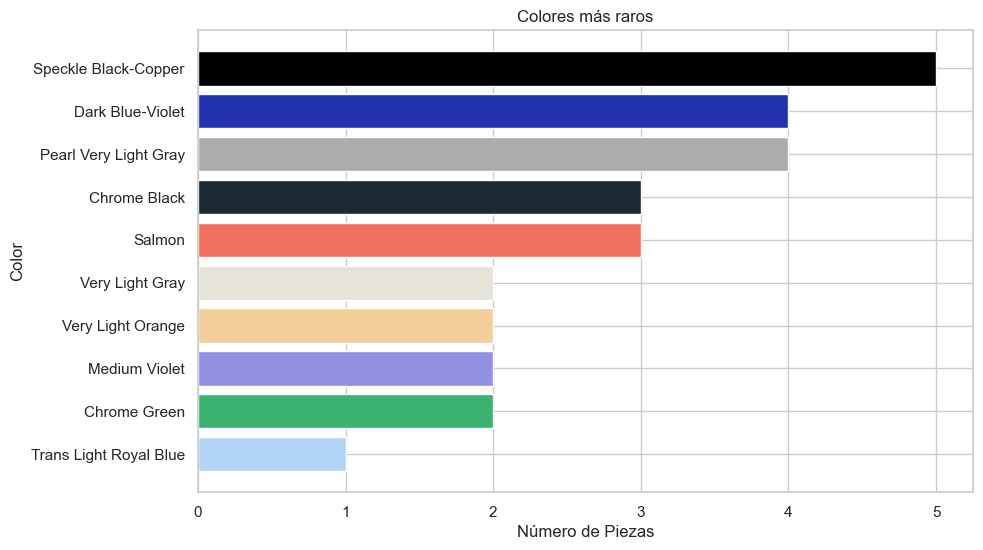

In [23]:
# Gráfico de barras - Colores más raros
# Convertir el color RGB en formato hexadecimal
rare_colors['color_hex'] = rare_colors['rgb'].apply(lambda x: f'#{x}')

# Crear gráfico
plt.figure(figsize=(10, 6))
bars = plt.barh(rare_colors['colors_name'], rare_colors['total_pieces'], color=rare_colors['color_hex'])

# Ajustar el título y las etiquetas
plt.title('Colores más raros')
plt.xlabel('Número de Piezas')
plt.ylabel('Color')

plt.show()

### La pieza más usada

La pieza que en más sets esta presente.

In [24]:
# La pieza más usada
consulta = '''SELECT 
    p.part_num,
    p.parts_name, 
    COUNT(ip.part_num) AS usage_count
FROM 
    parts p
JOIN 
    inventory_parts ip ON p.part_num = ip.part_num
GROUP BY 
    p.part_num, p.parts_name
ORDER BY 
    usage_count DESC
LIMIT 1;'''
most_common_part = pd.read_sql(consulta, con=engine)

In [25]:
most_common_part

,part_num,parts_name,usage_count
0,6141,Plate Round 1 x 1 with Solid Stud,16550


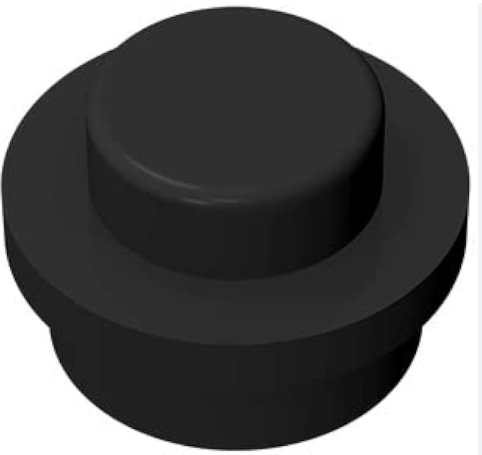

## Conclusiones del Proyecto
Este notebook proporciona un análisis exhaustivo del dataset de LEGO, desde piezas por colores hasta temas y rarezas. Al usar consultas SQL avanzadas y Python, hemos podido extraer información valiosa de los datos, que puede ser utilizada para comprender mejor la evolución de los sets de LEGO a lo largo de los años.